In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (3.6, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'legend.fontsize': 'small', 'axes.titlesize': 'medium',
    'axes.spines.top': False, 'axes.spines.right': False,
    'image.interpolation': 'nearest', 'savefig.dpi': 100,
})

import os
import torch
import pickle
from pathlib import Path
import numpy as np
from jarvis.utils import tqdm

from hexarena import STORE_DIR
FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

In [1]:
from hexarena.scripts.poisson_beliefs import *

subject = 'marco'
tau_in_state = True
n_samples = 2000
n_seeds = 6

block_infos = get_valid_blocks(subject, min_pos_ratio=0, min_gaze_ratio=0, min_push=10)
block_ids = [key for key in block_infos if block_infos[key]['gamma']==1]
configs = [Config({
    'session_id': session_id, 'block_idx': block_idx,
    'tau_in_state': tau_in_state, 'n_samples': n_samples,
    'seed': seed,
}) for session_id, block_idx in block_ids for seed in range(n_seeds)]

# Load one block of data

In [2]:
from hexarena.utils import get_valid_blocks

subject = 'marco'
block_infos = get_valid_blocks(subject, min_pos_ratio=0, min_gaze_ratio=0, min_push=10)
session_id, block_idx = next(key for key in block_infos if block_infos[key]['kappa']==0.1)
session_id, block_idx

('20211104', 0)

In [3]:
from hexarena.utils import load_monkey_data, align_monkey_data

block_data = load_monkey_data(subject, session_id, block_idx)
# align_monkey_data(block_data)

# Bandit environment

In [4]:
from hexarena.scripts.common import create_env

env = create_env(no_arena=True, tau_in_state=True)

env_data = env.convert_experiment_data(block_data)

agt_states, env_states, obss, actions = env.extract_episode(env_data)

# Compute beliefs

In [5]:
from irc.model import SamplingBeliefModel

cliques = {
    'env': [
        [('box_0', 'food'), ('box_0', 'tau', (0,))],
        [('box_1', 'food'), ('box_1', 'tau', (0,))],
        [('box_2', 'food'), ('box_2', 'tau', (0,))],
    ],
}
p_s = {
    'phis': [{'embedder': {'_target_': 'irc.dist.embedder.ConcatEmbedder'}}]*3,
}
model = SamplingBeliefModel(env, cliques=cliques, n_samples=2000, p_s=p_s)

In [6]:
model.use_sample = True
model.estimate_kw.update({'sga_kw': {'n_epochs': 100, 'lr': 0.01, 'batch_size': 100}, 'l2_reg': 1.})

model.update_spaces(span=4.)

# taus = torch.tensor(block_data['taus'])
# for i in [1, 3, 5]:
#     model.env_space.spaces[i].update_affine(taus)

In [ ]:
beliefs, infos = model.compute_beliefs(
    agt_states, obss, actions,
    ckpt_pth=STORE_DIR/subject/f'tau.beliefs/{session_id}-{block_idx}.pkl',
)

In [8]:
from jarvis.utils import array2tensor

with open('store/marco/tau.beliefs/20211104-0.pkl', 'rb') as f:
    ckpt = array2tensor(pickle.load(f))
beliefs = ckpt['beliefs']
infos = ckpt['infos']

In [7]:
belief, info = model.init_belief(agt_states[0], obss[0])
beliefs = [belief]
infos = [info]

In [8]:
n_steps = len(actions)
for t in tqdm(range(n_steps)):
    belief, info = model.update_belief(agt_states[t], belief, actions[t], agt_states[t+1], obss[t+1])
    beliefs.append(belief)
    infos.append(info)

beliefs = torch.stack(beliefs)

  0%|                                                                                                         …

In [11]:
def get_probs(p_s, belief, taus):
    param_dim = p_s.s_dists[0].param_dim
    ps = np.empty((3, 2, len(taus)))
    for i in range(3):
        dist = p_s.s_dists[i]
        param_vec = belief[i*param_dim:(i+1)*param_dim]
        xs = dist.spaces[1].encode(torch.tensor(taus, dtype=torch.float))
        for food in range(2):
            logps, _ = dist.loglikelihoods(
                torch.stack([torch.ones_like(xs)*food, xs], dim=1), param_vec, original=True,
            )
            ps[i, food] = logps.exp().numpy()
    return ps

In [37]:
[block_data['intervals'][i].mean() for i in range(3)]

[np.float64(19.240166666666667),
 np.float64(39.3946393442623),
 np.float64(13.336183673469389)]

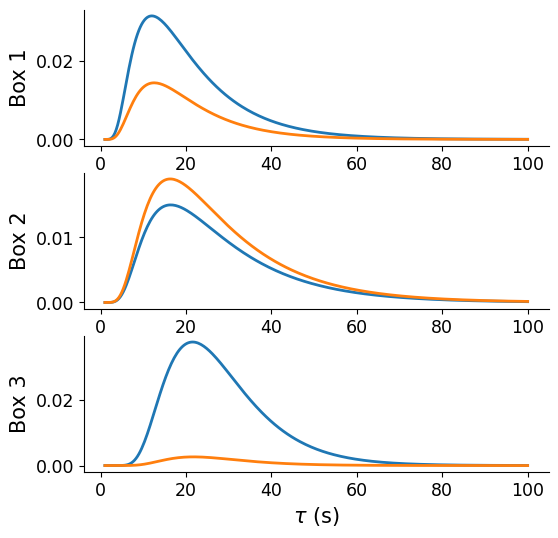

In [46]:
taus = np.linspace(1, 100, 300)
ps = get_probs(model.p_s, beliefs[300], taus)

_, axes = plt.subplots(3, 1, figsize=(6, 6))
for i, ax in enumerate(axes):
    for food in range(2):
        ax.plot(taus, ps[i, food])
    ax.set_ylabel(f'Box {i+1}')
ax = axes[-1]
ax.set_xlabel(r'$\tau$ (s)')
plt.show()

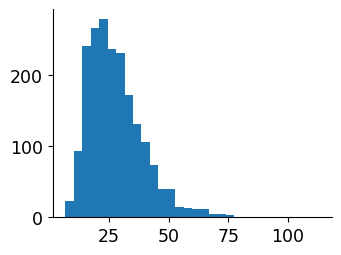

In [41]:
vals = model.env_space.spaces[5].decode(infos[200]['states'][:, 5])
_, ax = plt.subplots()
ax.hist(vals, 30)
plt.show()

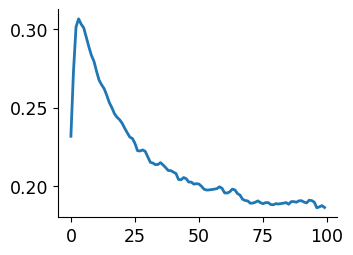

In [45]:
losses = infos[40]['estimate_stats']['losses_train']

_, ax = plt.subplots()
ax.plot(losses[:, 1])
plt.show()

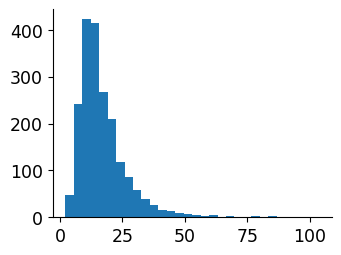

In [73]:
_, ax = plt.subplots()
ax.hist(model.env_space.spaces[5].decode(infos[44]['states'][:, 5]), 30)
plt.show()

In [46]:
ps_food = torch.softmax(beliefs.reshape(-1, 3, 2), dim=2)[..., 0]

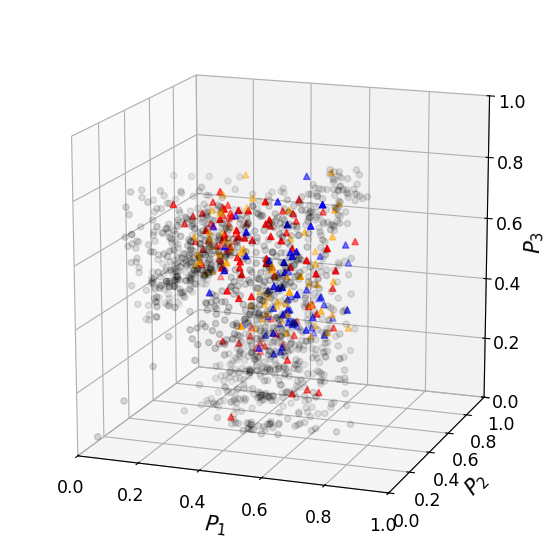

In [59]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.05, 0.05, 0.9, 0.9], projection='3d', elev=15)

for action in range(4):
    if action==0:
        marker = '^'
        color = 'blue'
    if action==1:
        marker = '^'
        color = 'orange'
    if action==2:
        marker = '^'
        color = 'red'
    if action==3:
        marker = 'o'
        color = (0, 0, 0, 0.2)
    idxs, = (actions==action).nonzero()
    ax.scatter(
        ps_food[idxs, 0], ps_food[idxs, 1], ps_food[idxs, 2],
        marker=marker, color=color,
    )
ax.set_xlim([0, 1]); ax.set_ylim([0, 1]); ax.set_zlim([0, 1]);
ax.set_aspect('equal')
ax.set_xlabel('$P_1$'); ax.set_ylabel('$P_2$'); ax.set_zlabel('$P_3$')

def update(t, total=36):
    az = (t/total)*360-60
    ax.view_init(azim=az)
    return []

total = 36
ani = FuncAnimation(
    fig, update, fargs=(total,), frames=range(total), blit=True,
)

HTML(ani.to_jshtml())